In [36]:
# Dependencies
from citipy import citipy
from random import uniform
import json
import requests
from pprint import pprint
from config import api_key
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date 
from scipy.stats import linregress

In [2]:
# Retrive 1000 citites objects from citipy
cities = []

while len(cities) <1000:
    latitude = uniform(90, -90)
    longitude = uniform(180, -180)
    new_city = citipy.nearest_city(latitude, longitude)
    if new_city not in cities:
        cities.append(new_city)    

In [3]:
# Building query and retreiving API query
city_info=[]
city_num = 0
request_date = date.today()
for city in cities:
    city_num+=1
    base_url = "http://api.openweathermap.org/data/2.5/weather?q="
    query_url = (f"{base_url}{city.city_name},{city.country_code}&units=imperial&appid={api_key}")
    weather_response= requests.get(query_url)
    city_info.append(weather_response.json())
    print(f"City count: {city_num}\n Retrieving data for {city.city_name} in {city.country_code}.")

City count: 1
 Retrieving data for karratha in au.
City count: 2
 Retrieving data for new norfolk in au.
City count: 3
 Retrieving data for acapulco in mx.
City count: 4
 Retrieving data for ribeira grande in pt.
City count: 5
 Retrieving data for port lincoln in au.
City count: 6
 Retrieving data for mataura in pf.
City count: 7
 Retrieving data for shatki in ru.
City count: 8
 Retrieving data for beloha in mg.
City count: 9
 Retrieving data for namibe in ao.
City count: 10
 Retrieving data for tura in ru.
City count: 11
 Retrieving data for jamestown in sh.
City count: 12
 Retrieving data for nikolskoye in ru.
City count: 13
 Retrieving data for impfondo in cg.
City count: 14
 Retrieving data for great falls in us.
City count: 15
 Retrieving data for lebu in cl.
City count: 16
 Retrieving data for hambantota in lk.
City count: 17
 Retrieving data for nang rong in th.
City count: 18
 Retrieving data for mahebourg in mu.
City count: 19
 Retrieving data for punta arenas in cl.
City coun

In [4]:
# Pretty Print response
pprint(city_info)

[{'base': 'stations',
  'clouds': {'all': 0},
  'cod': 200,
  'coord': {'lat': -20.7377, 'lon': 116.8463},
  'dt': 1616785152,
  'id': 6620339,
  'main': {'feels_like': 84.34,
           'grnd_level': 1006,
           'humidity': 68,
           'pressure': 1008,
           'sea_level': 1008,
           'temp': 81.86,
           'temp_max': 81.86,
           'temp_min': 81.86},
  'name': 'Karratha',
  'sys': {'country': 'AU', 'sunrise': 1616797095, 'sunset': 1616840258},
  'timezone': 28800,
  'visibility': 10000,
  'weather': [{'description': 'clear sky',
               'icon': '01n',
               'id': 800,
               'main': 'Clear'}],
  'wind': {'deg': 256, 'gust': 13.69, 'speed': 9.35}},
 {'base': 'stations',
  'clouds': {'all': 100},
  'cod': 200,
  'coord': {'lat': -42.7826, 'lon': 147.0587},
  'dt': 1616784890,
  'id': 2155415,
  'main': {'feels_like': 50.7,
           'humidity': 68,
           'pressure': 1003,
           'temp': 53.19,
           'temp_max': 55,
       

In [5]:
# Function to get values from a dictionary
def safe_get(d, *keys):
    value = d
    for key in keys:
        value = value.get(key,None)
        if value is None: break
    return value

# Using list comprehension to retrieve desired data by iterating through dicts in city_info and using function "safe_get".
weather_city_info = [
    {
        "City": safe_get(city,"name"),
        "Country": safe_get(city,"sys","country"), 
        "Latitude": safe_get(city, "coord","lat"),
        "Longitude": safe_get(city, "coord","lon"),
        "Temperature (F)": safe_get(city, "main","temp"),
        "Humidity %": safe_get(city,"main", "humidity"),
        "Cloudiness %": safe_get(city, "clouds","all"),
        "Wind Speed (mph)": safe_get(city, "wind","speed")
    } for city in city_info
]
pprint(weather_city_info)


[{'City': 'Karratha',
  'Cloudiness %': 0,
  'Country': 'AU',
  'Humidity %': 68,
  'Latitude': -20.7377,
  'Longitude': 116.8463,
  'Temperature (F)': 81.86,
  'Wind Speed (mph)': 9.35},
 {'City': 'New Norfolk',
  'Cloudiness %': 100,
  'Country': 'AU',
  'Humidity %': 68,
  'Latitude': -42.7826,
  'Longitude': 147.0587,
  'Temperature (F)': 53.19,
  'Wind Speed (mph)': 1.52},
 {'City': 'Acapulco de Juárez',
  'Cloudiness %': 20,
  'Country': 'MX',
  'Humidity %': 58,
  'Latitude': 16.8634,
  'Longitude': -99.8901,
  'Temperature (F)': 84.2,
  'Wind Speed (mph)': 9.22},
 {'City': 'Ribeira Grande',
  'Cloudiness %': 20,
  'Country': 'PT',
  'Humidity %': 55,
  'Latitude': 38.5167,
  'Longitude': -28.7,
  'Temperature (F)': 62.6,
  'Wind Speed (mph)': 9.22},
 {'City': 'Port Lincoln',
  'Cloudiness %': 0,
  'Country': 'AU',
  'Humidity %': 73,
  'Latitude': -34.7333,
  'Longitude': 135.8667,
  'Temperature (F)': 59.32,
  'Wind Speed (mph)': 9.78},
 {'City': None,
  'Cloudiness %': None,


In [6]:
weather_city_info_df = pd.DataFrame(weather_city_info)
weather_city_info_df

,City,Country,Latitude,Longitude,Temperature (F),Humidity %,Cloudiness %,Wind Speed (mph)
0,Karratha,AU,-20.7377,116.8463,81.86,68.0,0.0,9.35
1,New Norfolk,AU,-42.7826,147.0587,53.19,68.0,100.0,1.52
2,Acapulco de Juárez,MX,16.8634,-99.8901,84.20,58.0,20.0,9.22
3,Ribeira Grande,PT,38.5167,-28.7000,62.60,55.0,20.0,9.22
4,Port Lincoln,AU,-34.7333,135.8667,59.32,73.0,0.0,9.78
...,...,...,...,...,...,...,...,...
995,None,None,NaN,NaN,NaN,NaN,NaN,NaN
996,Pirovskoye,RU,57.6267,92.2658,23.23,95.0,100.0,8.41
997,Soskovo,RU,52.7475,35.3828,33.58,99.0,100.0,6.04
998,Bakurianis Andeziti,GE,41.7337,43.4724,25.34,98.0,100.0,2.86


In [7]:
# Find count of empty dictionaries
len([entry for entry in weather_city_info if entry["City"] is None])

98

In [15]:
# Drop rows without city information with dropna()
clean_weather_city_info_df= weather_city_info_df.dropna()
# Count number of cities with information
total_cities = len(clean_weather_city_info_df.index)
total_cities

902

In [9]:
clean_weather_city_info_df

,City,Country,Latitude,Longitude,Temperature (F),Humidity %,Cloudiness %,Wind Speed (mph)
0,Karratha,AU,-20.7377,116.8463,81.86,68.0,0.0,9.35
1,New Norfolk,AU,-42.7826,147.0587,53.19,68.0,100.0,1.52
2,Acapulco de Juárez,MX,16.8634,-99.8901,84.20,58.0,20.0,9.22
3,Ribeira Grande,PT,38.5167,-28.7000,62.60,55.0,20.0,9.22
4,Port Lincoln,AU,-34.7333,135.8667,59.32,73.0,0.0,9.78
...,...,...,...,...,...,...,...,...
994,Mkwanga,TZ,-7.1180,39.2078,78.80,89.0,20.0,5.75
996,Pirovskoye,RU,57.6267,92.2658,23.23,95.0,100.0,8.41
997,Soskovo,RU,52.7475,35.3828,33.58,99.0,100.0,6.04
998,Bakurianis Andeziti,GE,41.7337,43.4724,25.34,98.0,100.0,2.86


In [10]:
# Write data frame data into csv
clean_weather_city_info_df.to_csv('Outputs/weather_data.csv', index= False, header= True)


In [11]:
# Copy data frame for integrity
data_df = clean_weather_city_info_df.copy()


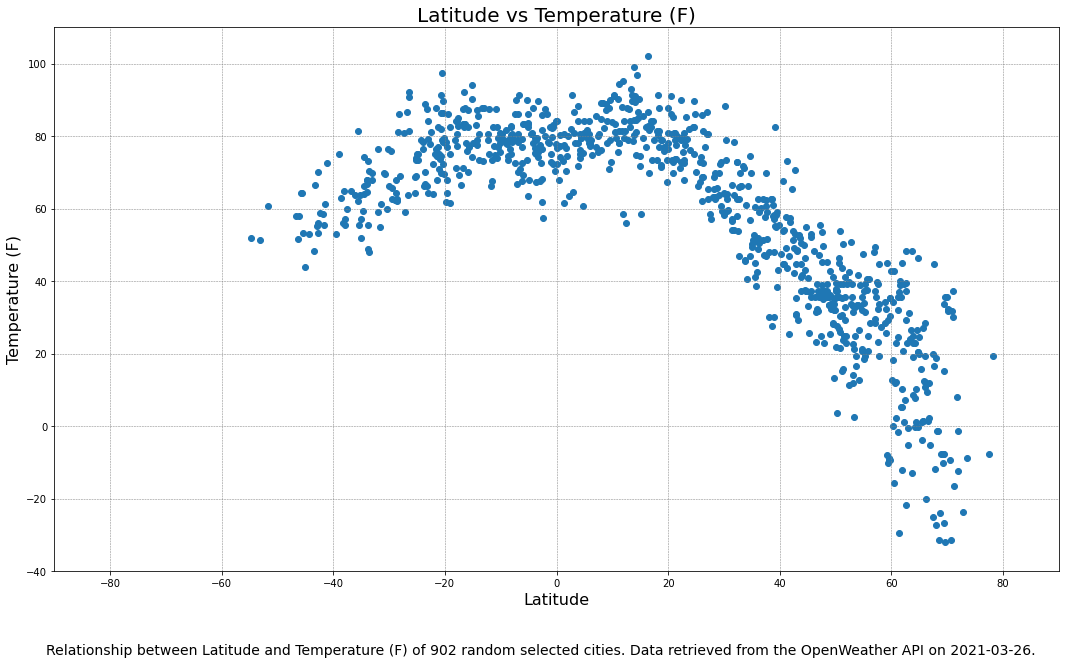

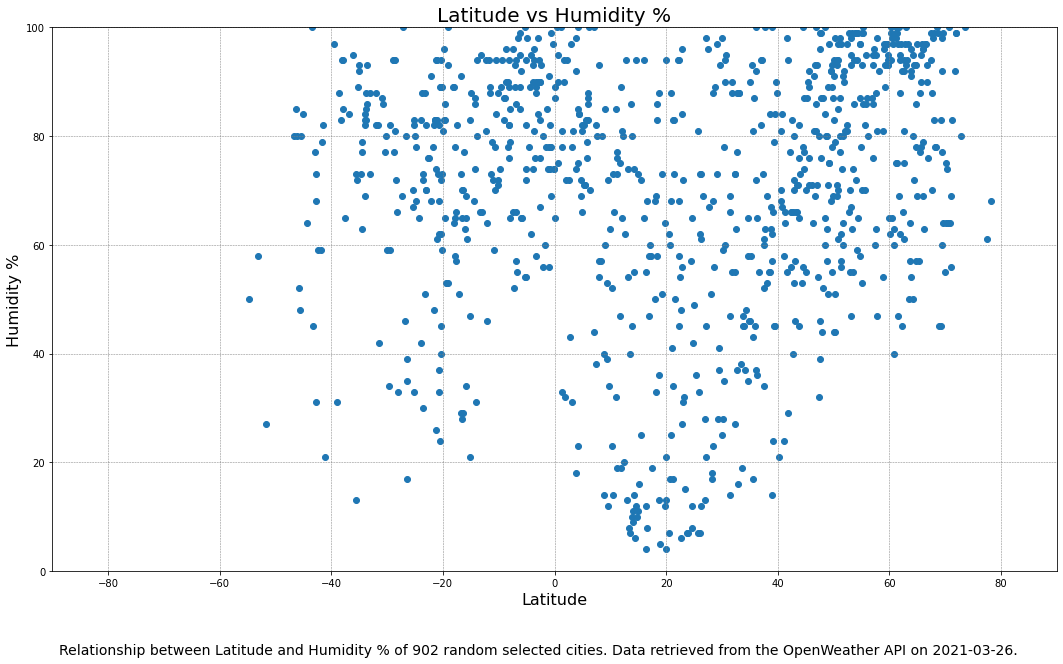

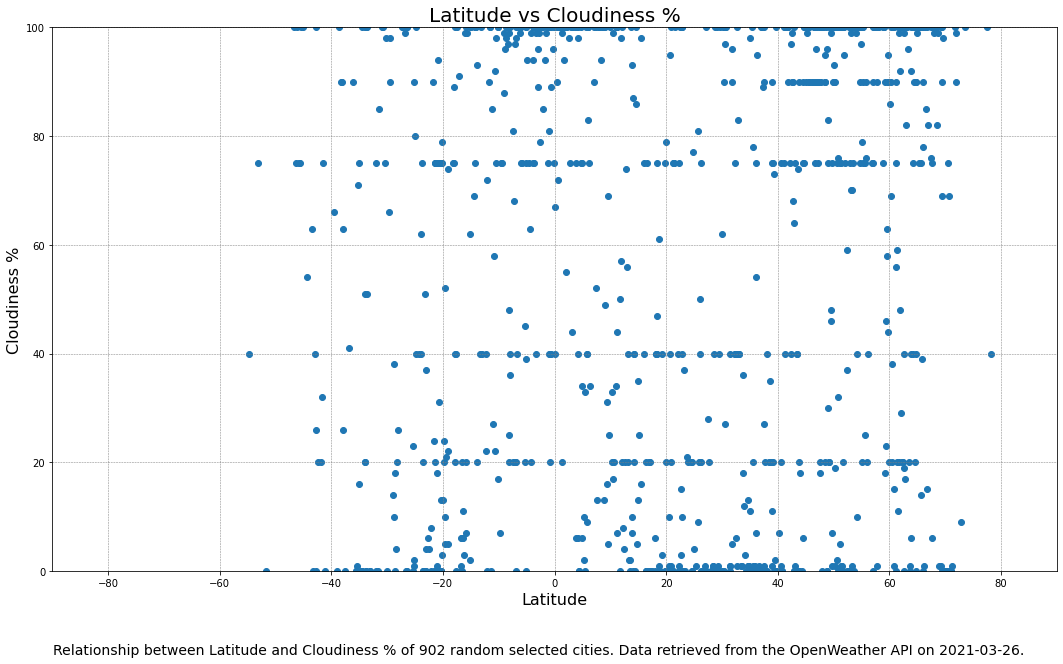

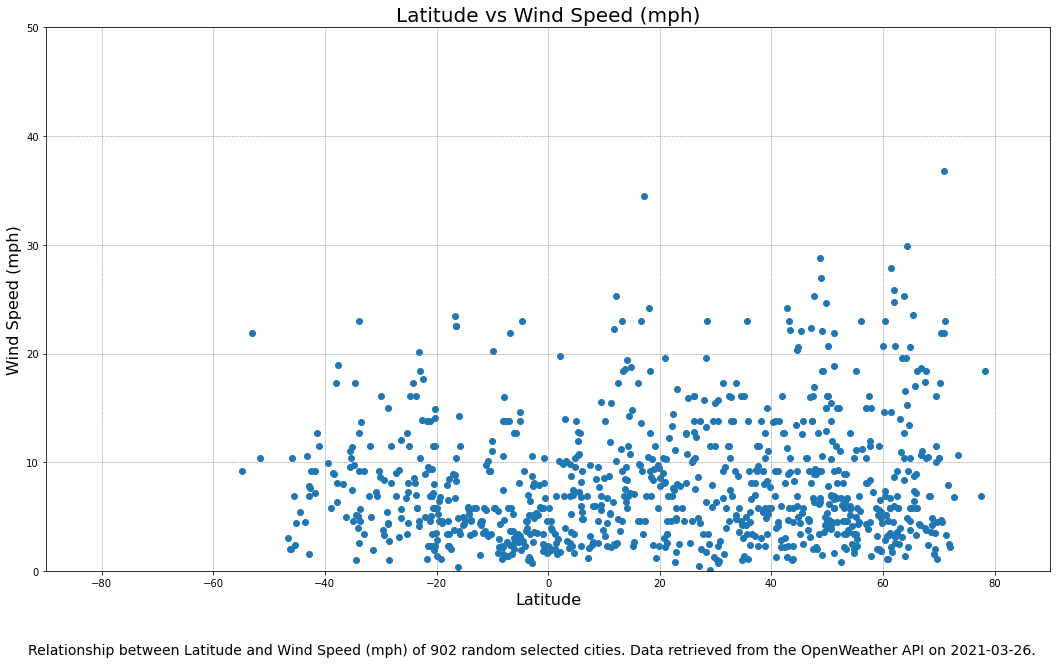

In [35]:
# Function to make scatter plots:
column_names=["Temperature (F)", "Humidity %", "Cloudiness %", "Wind Speed (mph)"]
for type in column_names:
    plt.figure(figsize= (18,10))
    plt.scatter(data_df["Latitude"], data_df[type])
    plt.xlim([-90, 90])
    if type == "Temperature (F)":
        plt.ylim(round(min(data_df[type]),-1)-10,round(max(data_df[type]),-1)+10)
    elif type == "Wind Speed (mph)":
        plt.ylim(0,round(max(data_df[type]),-1)+10)
    else:
        plt.ylim([0,100])
    plt.title(f"Latitude vs {type}", fontsize=20)
    plt.xlabel("Latitude", fontsize=16)
    plt.ylabel(type, fontsize=16)
    plt.grid(color= "gray", linestyle="--", linewidth= 0.5)
    txt= (f"Relationship between Latitude and {type} of {total_cities} random selected cities. Data retrieved from the OpenWeather API on {request_date}.")
    plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
    plt.savefig(f"Outputs/{type}_scatter.png", dpi=600, transparent=False)
    plt.show()
    

In [38]:
# Split data into two data frames by hemisphere (northern and southern) and reset the index
northern_data_df= data_df.loc[data_df["Latitude"]>0].reset_index(drop= True)
southern_data_df= data_df.loc[data_df["Latitude"]<0].reset_index(drop= True)
# Count the number of cities in eah hemisphere
northern_cities= len(northern_data_df.index)
soutthern_cities= len(southern_data_df.index)
# Print new data frames and city counts
print(northern_data_df.head())
print(northern_cities)
print(southern_data_df.head())
print(soutthern_cities)

                 City Country  Latitude  Longitude  Temperature (F)  \
0  Acapulco de Juárez      MX   16.8634   -99.8901            84.20   
1      Ribeira Grande      PT   38.5167   -28.7000            62.60   
2              Shatki      RU   55.1887    44.1249            33.94   
3                Tura      RU   64.2833   100.2500             7.84   
4          Nikolskoye      RU   59.7035    30.7861            35.29   

   Humidity %  Cloudiness %  Wind Speed (mph)  
0        58.0          20.0              9.22  
1        55.0          20.0              9.22  
2        99.0         100.0              4.99  
3        95.0         100.0              4.90  
4        93.0          90.0              1.88  
615
           City Country  Latitude  Longitude  Temperature (F)  Humidity %  \
0      Karratha      AU  -20.7377   116.8463            81.86        68.0   
1   New Norfolk      AU  -42.7826   147.0587            53.19        68.0   
2  Port Lincoln      AU  -34.7333   135.8667      

In [82]:
# Regression plots per hemisphere

def regress (df, list):
    hemisphere= input("Northern or Southern hemisphere? ")
    #Use linregress to calculate the line equation and r-value
    for type in list:
        (slope, intercept, rvalue, pvalue, stderr)= linregress(df["Latitude"],df[type])
        regress_values= df["Latitude"] * slope + intercept
        line_equation = (f"y={str(round(slope,2))}x + {str(round(intercept,2))}")
        
        fig= plt.figure(figsize= (18,10))
        add_axes(ax)
        plt.scatter(df["Latitude"], df[type])
        plt.xlabel("Latitude")
        plt.ylabel(type)
        plt.xlim([-90, 90])
        if type == "Temperature (F)":
            plt.ylim(round(min(data_df[type]),-1)-10,round(max(data_df[type]),-1)+10)
        elif type == "Wind Speed (mph)":
            plt.ylim(0,round(max(data_df[type]),-1)+10)
        else:
            plt.ylim([0,100])
        plt.title(f"{hemisphere} Hemisphere: Latitude vs {type}", fontsize=20)
        plt.xlabel("Latitude", fontsize=16)
        plt.ylabel(type, fontsize=16)
        plt.grid(color= "gray", linestyle="--", linewidth= 0.5)        

        plt.plot(df["Latitude"], regress_values, "r-")
        plt.text(1, 1, (f"{line_equation} \n r-squared = {round(rvalue**2,2)}"), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)

        # plt.text(0.5,0.5,'Hello World !',horizontalalignment='center',
    #  verticalalignment='center', transform = ax.transAxes)
        
        txt= (f"Relationship between Latitude and {type} of {total_cities} random selected cities. Data retrieved from the OpenWeather API on {request_date}.")
        plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
        plt.savefig(f"Outputs/{hemisphere}_{type}_regression.png", dpi=600, transparent=False)
        plt.show()


In [83]:
regress(northern_data_df, column_names)

NameError: name 'add_axes' is not defined

In [ ]:

for type in column_names:
    if data_df["Latitude"] >0:
        hemisphere = "Northern Hemisphere"
        regress(northern_data_df, column_names)
    elif data_df["Latitude"] <0:
        hemisphere = "Southern Hemisphere"


In [ ]:
linregress(df['col_X'], df['col_Y'])

# Perform a linear regression on temperature vs. latitude

# convert list to numpy array; allows projecting arithmetic operators over items
x_values = np.array(temp) 
y_values = np.array(lat)
# Use linregress to calculate the line equation and r-value
(slope, intercept, rvalue, pvalue, stderr)= linregress(x_values, y_values)
regress_values= x_values * slope + intercept
line_equation = (f"y={str(round(slope,2))}x + {str(round(intercept,2))}")
# Make the scatter plot
plt.scatter(x_values, y_values)
# Add the regression line
plt.plot(x_values, regress_values, "r-")
# Add text box with the line equation
plt.text(20.45,60, line_equation, bbox=dict(facecolor= 'red', alpha=0.5))
# Add text box with the r-value
plt.text(20.9, 55.8, (f"r-squared = {round(rvalue**2,2)}"), bbox= dict(facecolor= 'red', alpha= 0.5))
# Add labels and show plot
plt.xlabel("Temperature (C)")
plt.ylabel("Latitude")
plt.show()
# Print the r-squared
print(f'The r-squared is: {round(rvalue**2,2)}')